### Load required modules 

In [1]:
import warnings
import numpy as np
import scanpy as sc
import scarches as sca
import matplotlib.pyplot as plt

### Set up working environment

In [2]:
warnings.simplefilter(action = 'ignore')
# sc.settings.verbosity = 3
# sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 200, color_map = 'RdPu', dpi_save = 300, vector_friendly = True, format = 'svg')

In [73]:
sc.settings.set_figure_params(dpi = 200, color_map = 'RdPu', dpi_save = 300, vector_friendly = True, format = 'svg')

- Check GPU type assigned by `colab`

In [112]:
PT141_training = sc.read_h5ad('PT149.h5ad')
PT141_training

AnnData object with n_obs × n_vars = 76344 × 31664
    obs: 'hto_demux', 'sample', 'pass_QC', 'num_features', 'feature_call', 'num_umis', 'batch', 'guide_call', 'KO_call'
    var: 'gene_ids', 'feature_types'

In [113]:
PT141_training.layers['counts'] = PT141_training.X.copy()

### Add module genes

- Here I have selected the C2 modules from the repo, and I have added the C3 Immune-related modules from GSEA. 

In [114]:
path_gmt = '../metadata/'

sca.add_annotations(PT141_training, 
                    [path_gmt + 'c2.cp.reactome.v4.0.symbols.gmt'], 
                    min_genes = 15, clean = False)

PT141_training._inplace_subset_var(PT141_training.varm['I'].sum(1) > 0)

/home/mo/miniconda3/envs/pytorch/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


### Process module genes that match input
- Although the processed data comes with 7K HVGs already labelled in the `adata` object, I selected 2K HVGs to make things faster. 

In [115]:
sc.pp.normalize_per_cell(PT141_training)
sc.pp.log1p(PT141_training)

In [116]:
PT141_training.raw = PT141_training

In [117]:
sc.pp.highly_variable_genes(
    PT141_training,
    n_top_genes = 4000,
    layer = "counts",
    batch_key = "sample",
    subset = True,
    span = 1
)
PT141_training

/home/mo/miniconda3/envs/pytorch/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/mo/miniconda3/envs/pytorch/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/mo/miniconda3/envs/pytorch/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


AnnData object with n_obs × n_vars = 76344 × 4000
    obs: 'hto_demux', 'sample', 'pass_QC', 'num_features', 'feature_call', 'num_umis', 'batch', 'guide_call', 'KO_call', 'n_counts'
    var: 'gene_ids', 'feature_types', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'terms', 'log1p', 'hvg'
    varm: 'I'
    layers: 'counts'

In [118]:
select_terms = PT141_training.varm['I'].sum(0) > 20
PT141_training.uns['terms'] = np.array(PT141_training.uns['terms'])[select_terms].tolist()
PT141_training.varm['I'] = PT141_training.varm['I'][:, select_terms]
PT141_training._inplace_subset_var(PT141_training.varm['I'].sum(1) > 0)
PT141_training.X = PT141_training.layers["counts"].copy()

In [119]:
sc.pp.neighbors(PT141_training)

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [120]:
sc.tl.umap(PT141_training)

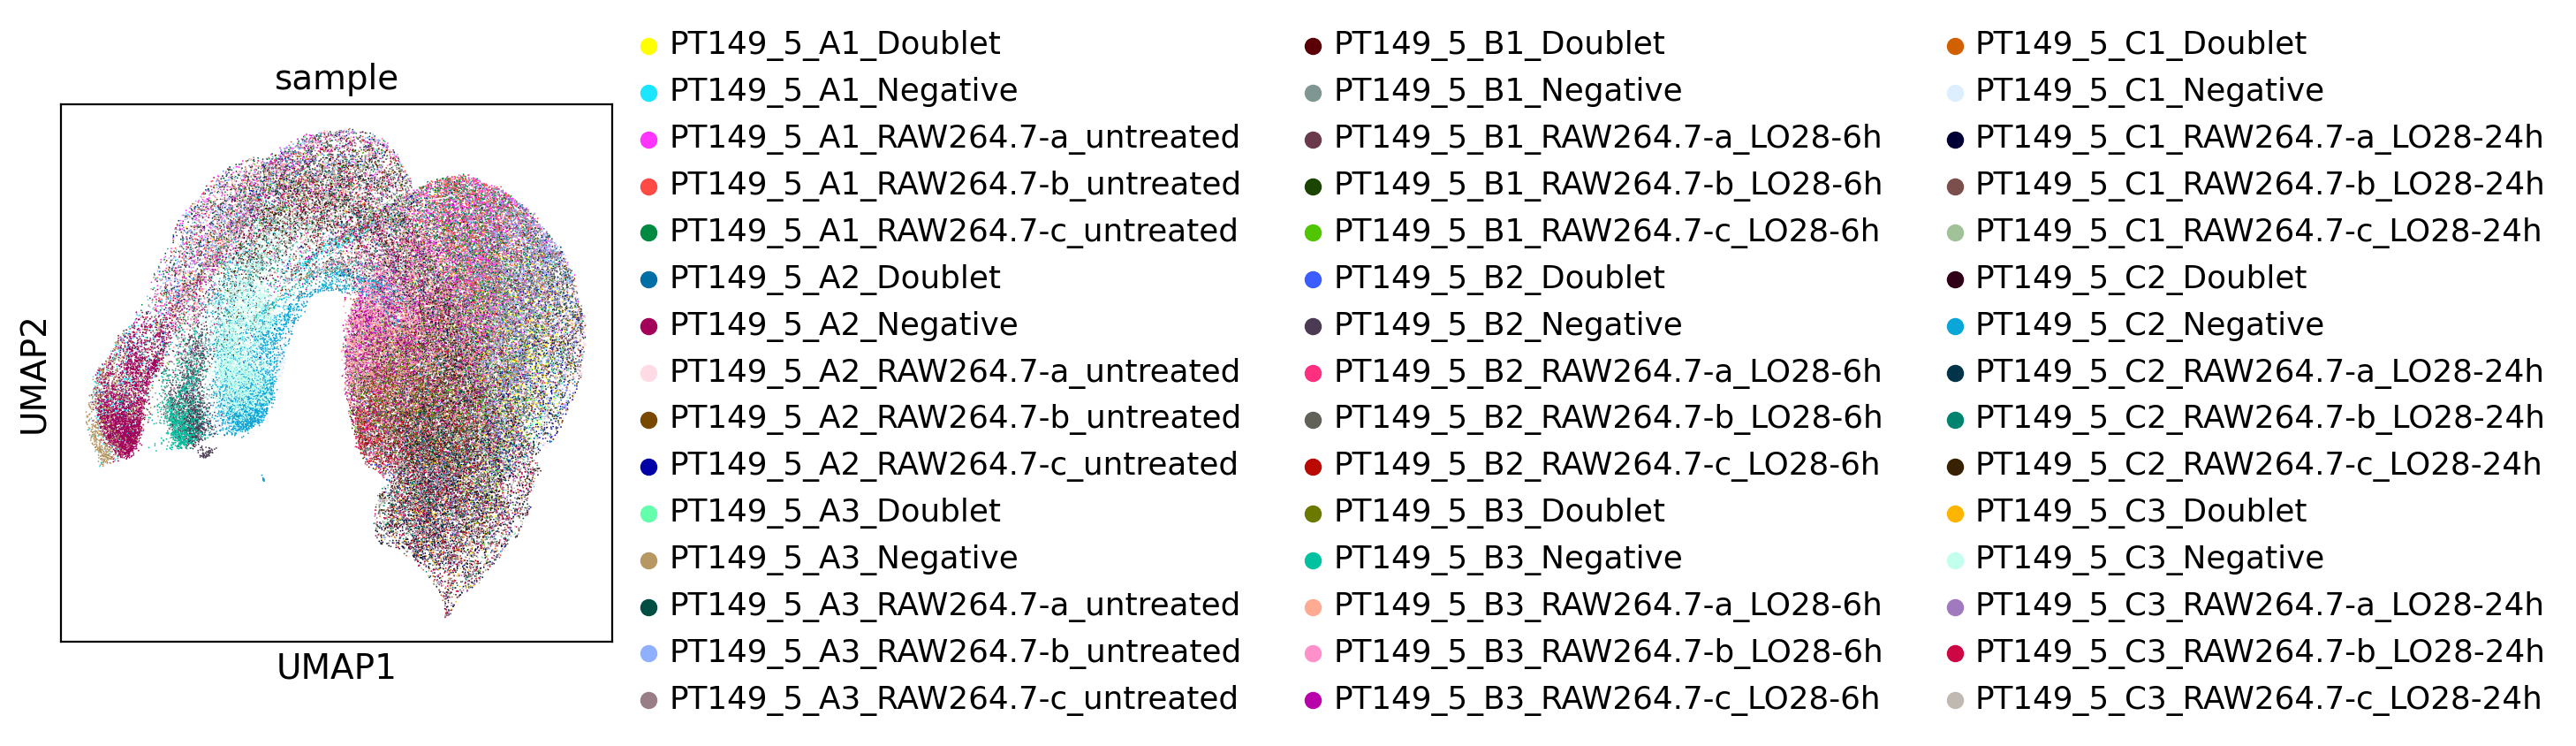

In [121]:
sc.pl.umap(PT141_training, color=['sample'])

### Create expimap model and train it on reference dataset

In [125]:
intr_cvae = sca.models.TRVAE(
    adata = PT141_training,
    condition_key = 'sample',
    hidden_layer_sizes = [351, 351],
    use_mmd = False,
    recon_loss = 'nb',
    mask = PT141_training.varm['I'].T,
    use_decoder_relu = False,
    mmd_instead_kl = False
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 3967 351 45
	Hidden Layer 1 in/out: 351 351
	Mean/Var Layer in/out: 351 351
Decoder Architecture:
	Masked linear layer in, out and cond:  351 3967 45


- Set up training parameters 

In [126]:
ALPHA = 0.7

In [127]:
OMEGA = None

In [128]:
early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss",
    "threshold": 0,
    "patience": 50,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}

In [129]:
intr_cvae.train(
    n_epochs = 200, 
    alpha_epoch_anneal = 50, 
    alpha = ALPHA, 
    omega = OMEGA,
    alpha_kl = 0.001,
    weight_decay = 0., 
    early_stopping_kwargs = early_stopping_kwargs,
    use_early_stopping = True,
    seed = 1712,
    print_n_deactive = False)

/home/mo/miniconda3/envs/pytorch/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


 |███████-------------| 38.0%  - epoch_loss: 3151.11 - epoch_recon_loss: 3138.59 - epoch_kl_loss: 12522.48 - val_loss: 2888.84 - val_recon_loss: 2876.74 - val_kl_loss: 12101.39
ADJUSTED LR
 |████████------------| 44.5%  - epoch_loss: 3142.14 - epoch_recon_loss: 3129.08 - epoch_kl_loss: 13066.23 - val_loss: 2879.65 - val_recon_loss: 2866.94 - val_kl_loss: 12715.47
ADJUSTED LR
 |██████████----------| 51.0%  - epoch_loss: 3137.71 - epoch_recon_loss: 3124.62 - epoch_kl_loss: 13094.86 - val_loss: 2879.56 - val_recon_loss: 2866.85 - val_kl_loss: 12718.13
ADJUSTED LR
 |███████████---------| 56.5%  - epoch_loss: 3151.40 - epoch_recon_loss: 3138.31 - epoch_kl_loss: 13096.75 - val_loss: 2881.92 - val_recon_loss: 2869.19 - val_kl_loss: 12729.19
Stopping early: no improvement of more than 0 nats in 50 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 61


### Checl terms in results

In [130]:
intr_cvae.save('ko_model_big_ref')

In [131]:
inactive_idx = ~(intr_cvae.model.decoder.L0.expr_L.weight.data.norm(p = 2, dim = 0) > 0).cpu().numpy()

In [132]:
print('Inactive terms:')
[term for i, term in enumerate(PT141_training.uns['terms']) if inactive_idx[i]]

Inactive terms:


['REACTOME_NCAM1_INTERACTIONS']

### Visualise manifold

In [133]:
MEAN = False
PT141_training.obsm['X_cvae'] = intr_cvae.get_latent(PT141_training.X.A, PT141_training.obs['sample'].tolist(),
                                                     mean = MEAN)[:, ~inactive_idx]

In [134]:
sc.pp.neighbors(PT141_training, use_rep = "X_cvae")
sc.tl.umap(PT141_training)

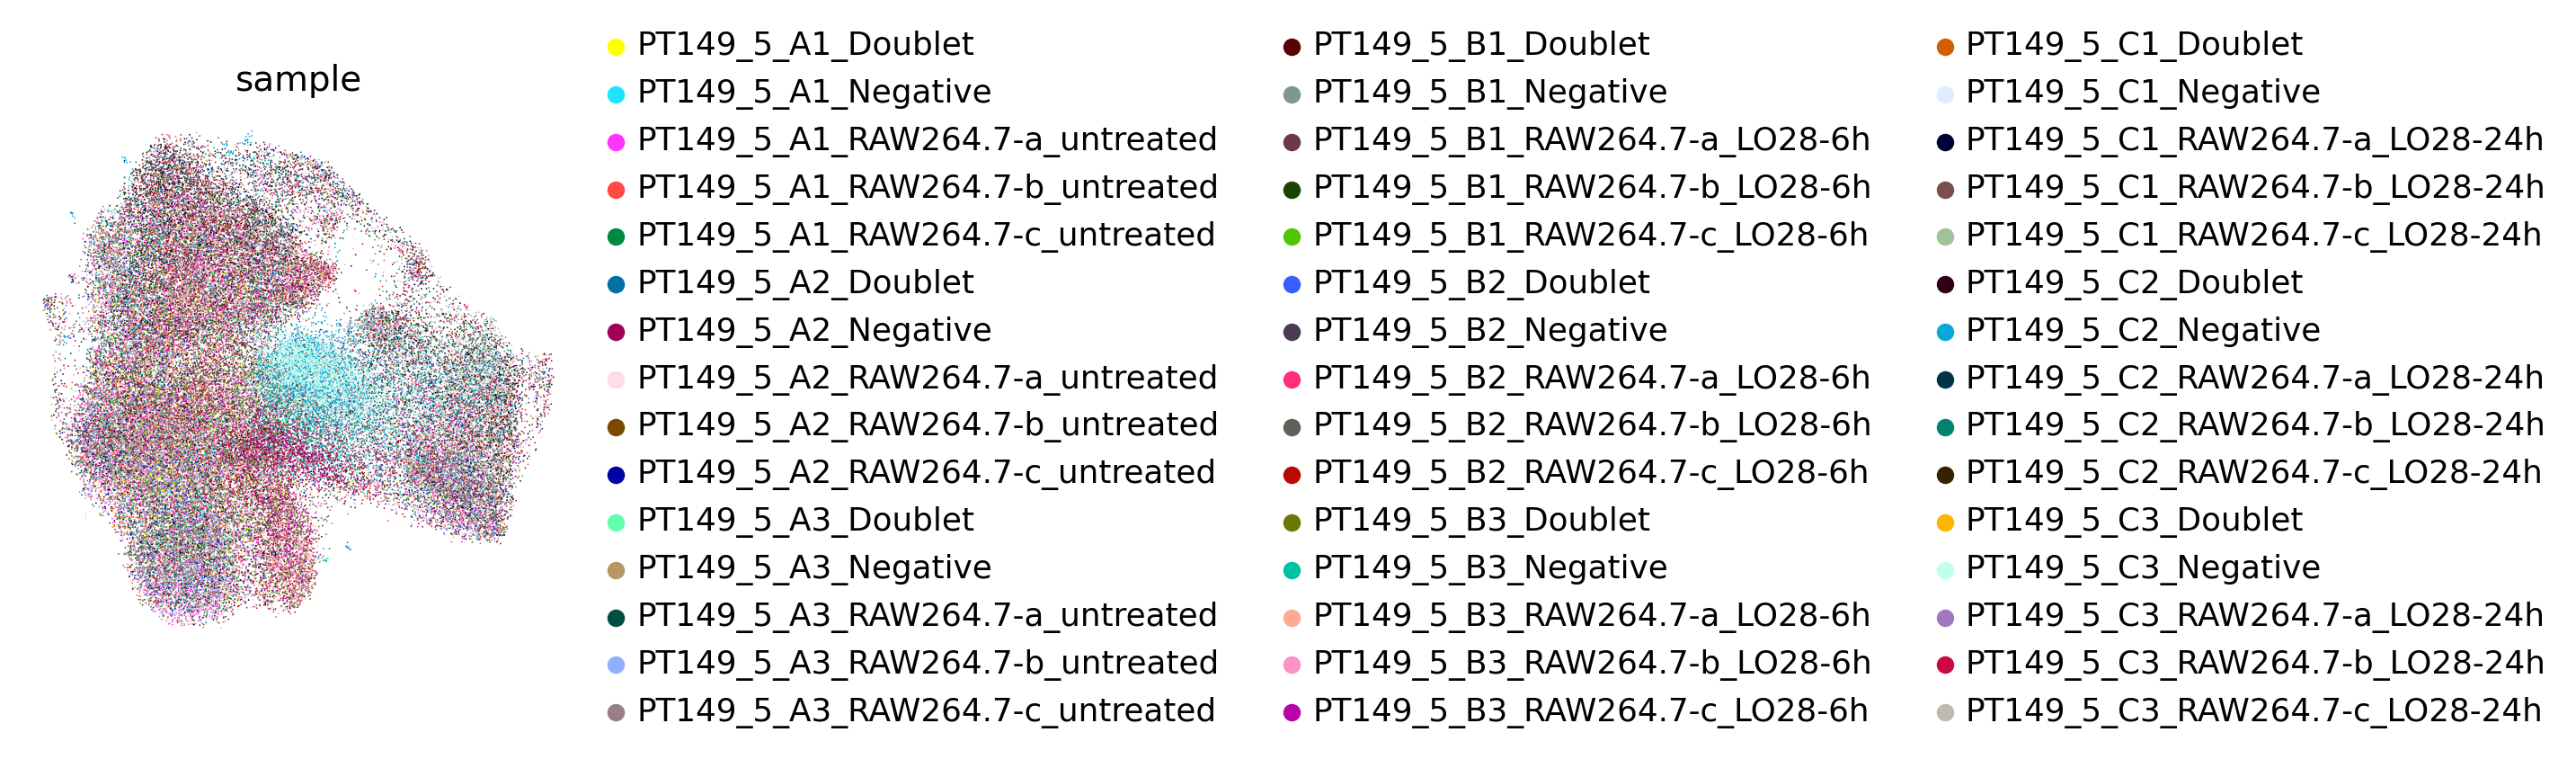

In [135]:
sc.pl.umap(PT141_training, frameon = False, color = ['sample'], wspace=0.5)

### Read in query data 

In [136]:
PT141 = sc.read_h5ad('PT141.h5ad')[:, PT141_training.var_names].copy()


/home/mo/miniconda3/envs/pytorch/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


### Format cells for analysis 

### Train on cells

In [137]:
PT141.X = PT141.X.A

In [148]:
q_intr_cvae = sca.models.TRVAE.load_query_data(PT141, intr_cvae)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 3967 351 55
	Hidden Layer 1 in/out: 351 351
	Mean/Var Layer in/out: 351 351
Decoder Architecture:
	Masked linear layer in, out and cond:  351 3967 55


In [149]:
q_intr_cvae.train(n_epochs = 100, alpha_epoch_anneal = 20, weight_decay = 0., alpha_kl = 0.001, seed = 1786)

/home/mo/miniconda3/envs/pytorch/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


 |████████████████████| 100.0%  - epoch_loss: 2470.45 - epoch_recon_loss: 2458.13 - epoch_kl_loss: 12318.51 - val_loss: 2464.62 - val_recon_loss: 2452.22 - val_kl_loss: 12391.79
Saving best state of network...
Best State was in Epoch 99


In [157]:
intr_cvae.save('ko_model_big_ref+q')

### Visualise joint manifold for query 

In [150]:
PT141.obsm['X_cvae'] = q_intr_cvae.get_latent(mean=MEAN)[:, ~inactive_idx]

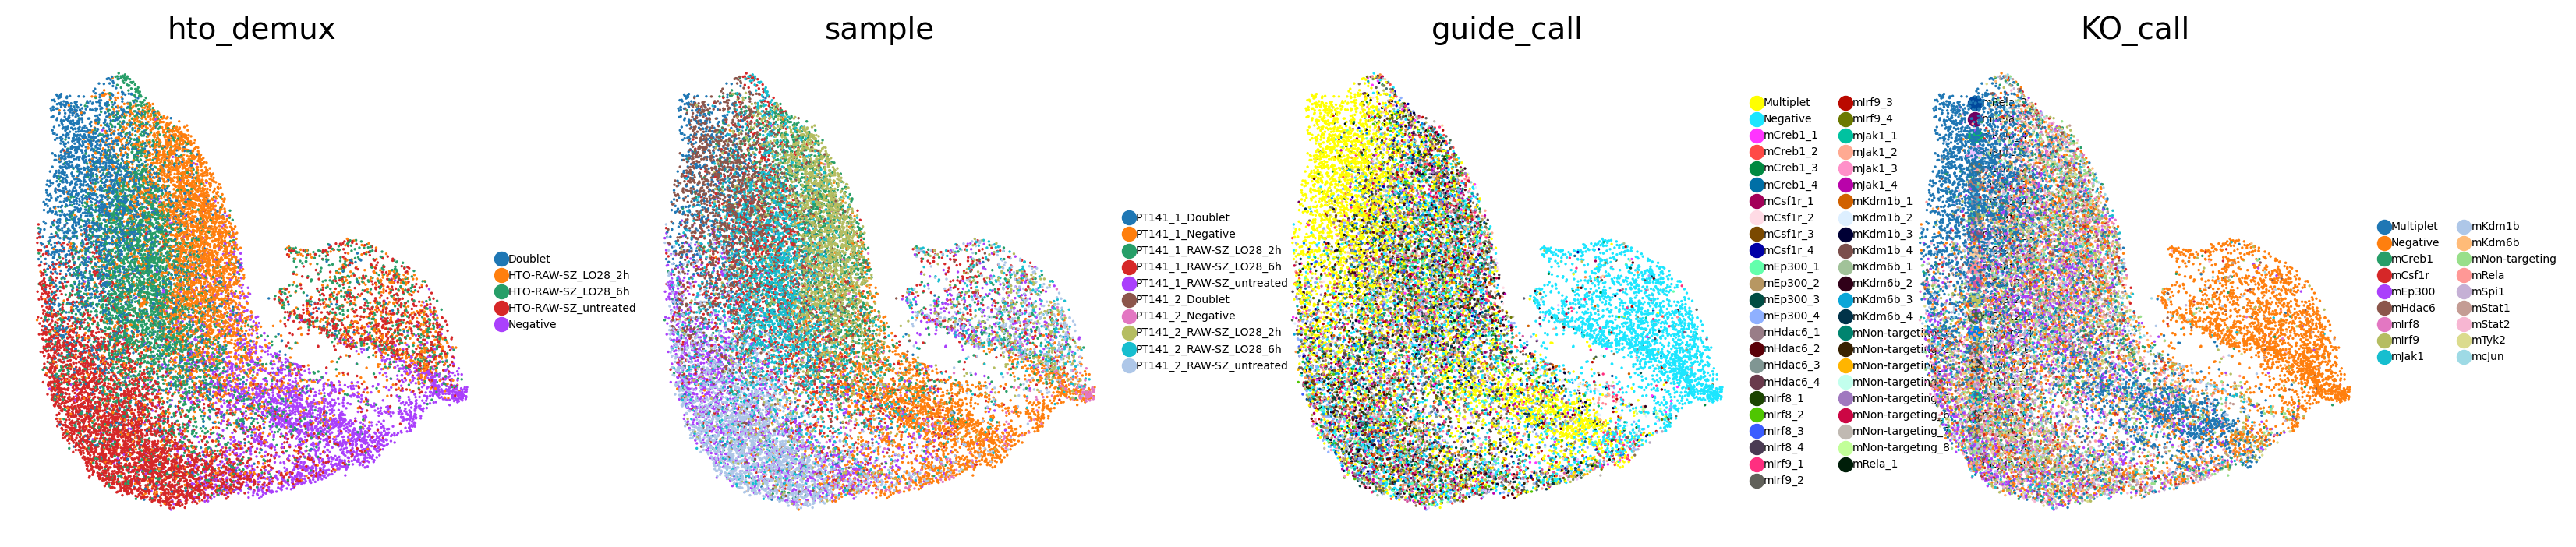

In [151]:
sc.pp.neighbors(PT141)
sc.tl.umap(PT141)
sc.pl.umap(PT141, frameon = False, color = ['hto_demux', 'sample', 'guide_call', 'KO_call'], legend_fontsize = 5)

### Get joint representation

In [173]:
ko_macro = sc.AnnData.concatenate(PT141_training, PT141, batch_key = 'batch_join')
ko_macro

/home/mo/miniconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/merge.py:891: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


AnnData object with n_obs × n_vars = 96393 × 3967
    obs: 'hto_demux', 'sample', 'pass_QC', 'num_features', 'feature_call', 'num_umis', 'batch', 'guide_call', 'KO_call', 'n_counts', 'REACTOME_CELL_CELL_COMMUNICATION', 'REACTOME_INTERFERON_ALPHA_BETA_SIGNALING', 'REACTOME_INTERFERON_GAMMA_SIGNALING', 'batch_join'
    var: 'gene_ids', 'feature_types', 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'highly_variable_nbatches-0', 'highly_variable_intersection-0'
    obsm: 'X_cvae', 'X_pca', 'X_umap'

In [174]:
ko_macro.obsm['X_cvae'] = q_intr_cvae.get_latent(ko_macro.X.A, ko_macro.obs['sample'].tolist(), mean = MEAN)[:, ~inactive_idx]

In [154]:
sc.pp.neighbors(ko_macro, use_rep = "X_cvae")
sc.tl.umap(ko_macro)

In [ ]:
sc.pl.umap(ko_macro, frameon = False, color = ['batch_join'], wspace=0.5)

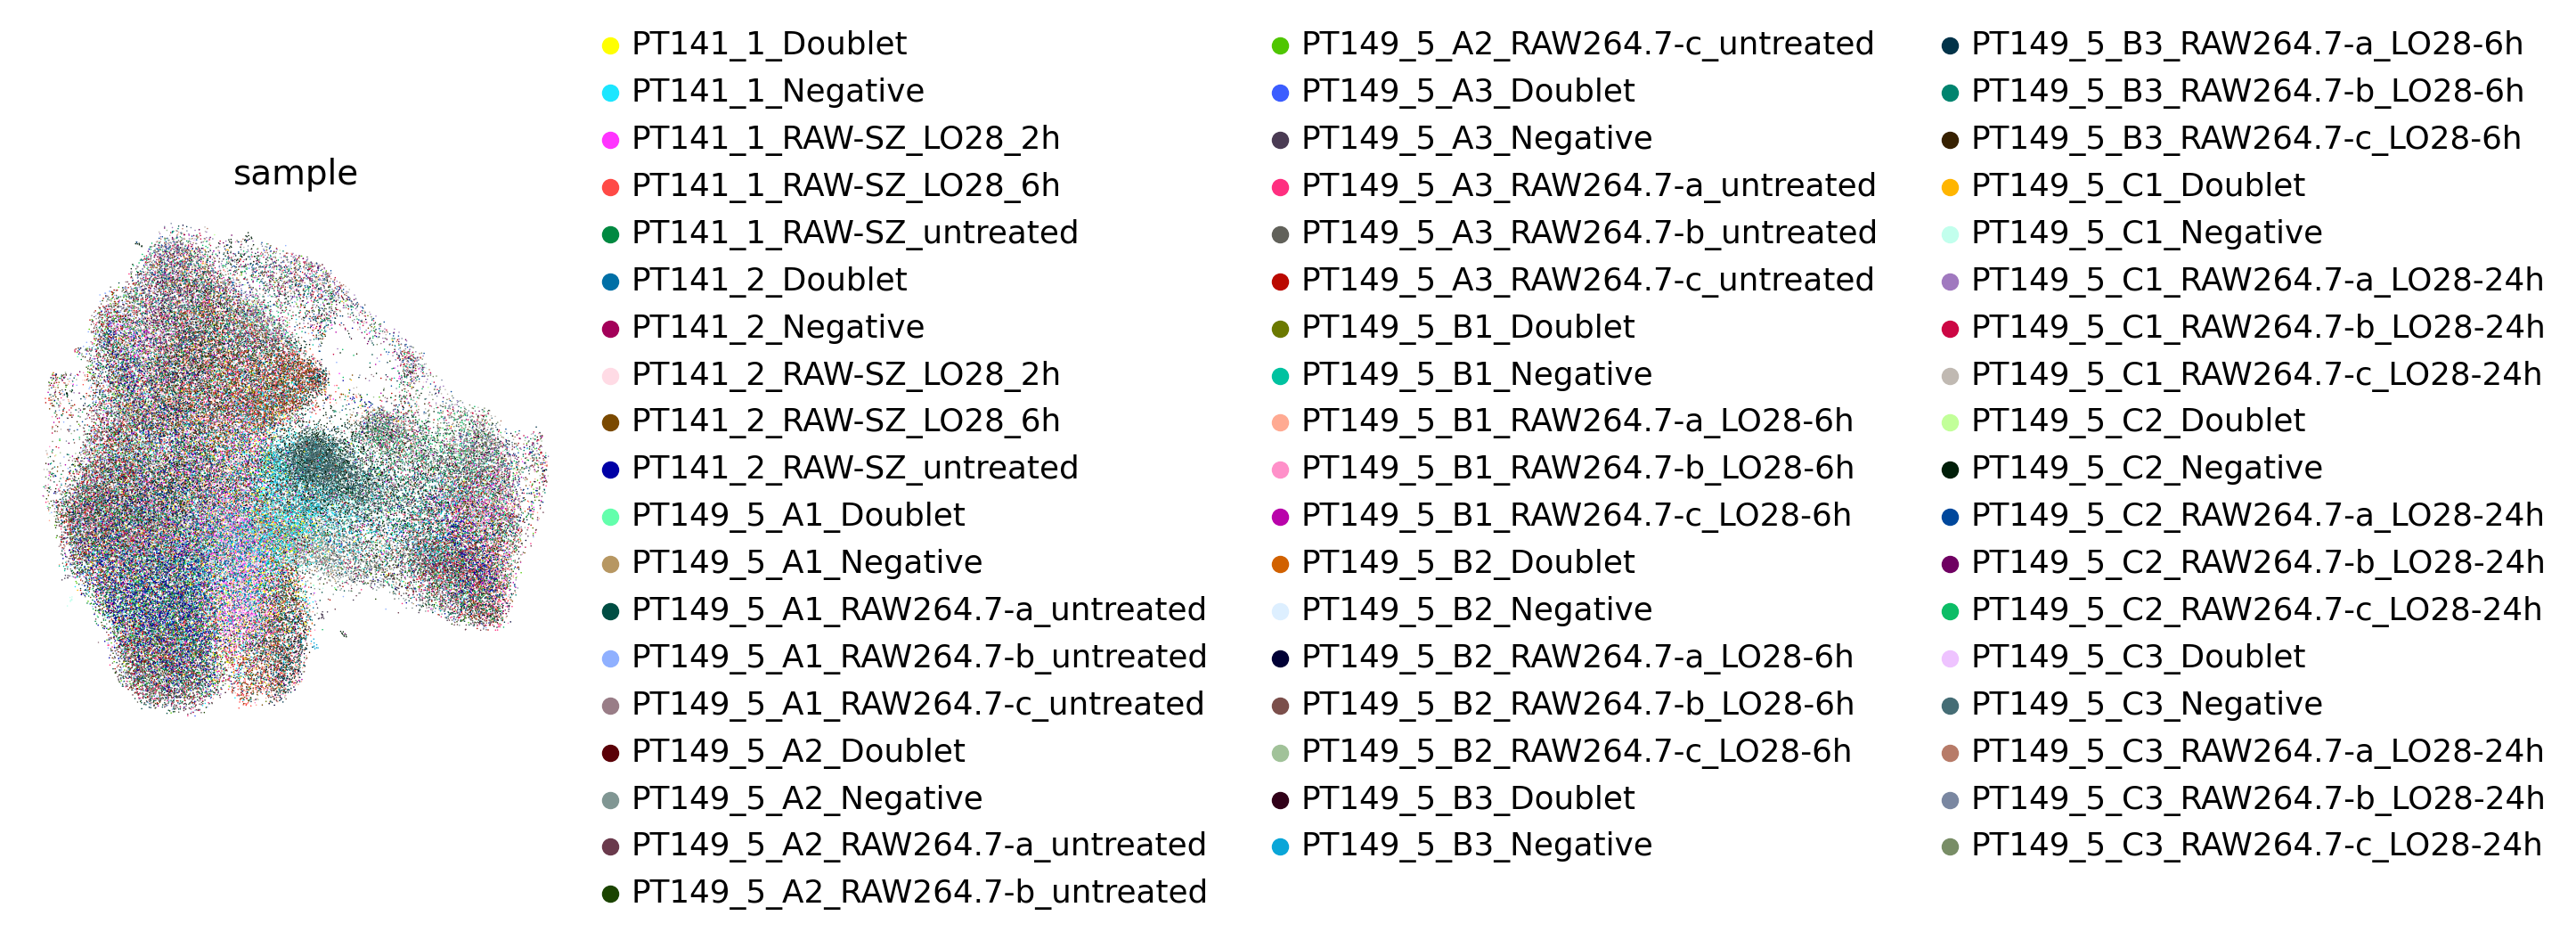

In [156]:
sc.pl.umap(ko_macro, frameon = False, color = ['sample'], wspace=0.5)

In [176]:
ko_macro.uns["terms"] = PT141_training.uns["terms"]

saving raw data  for all genes

In [178]:
adata_ref = sc.read("./PT149.h5ad")
query = sc.read("./PT141.h5ad")

In [179]:
ref_q = sc.AnnData.concatenate(adata_ref, query, batch_key = 'batch_join') 

In [182]:
sc.pp.normalize_per_cell(ref_q)

/home/mo/miniconda3/envs/pytorch/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [183]:
sc.pp.log1p(ref_q)

In [184]:
ko_macro.raw = ref_q

saving integrated object

In [185]:
ko_macro.write("mac_q_ref_integrated.h5ad")

... storing 'hto_demux' as categorical
... storing 'sample' as categorical
... storing 'feature_call' as categorical
... storing 'num_umis' as categorical
... storing 'batch' as categorical
... storing 'guide_call' as categorical
... storing 'KO_call' as categorical
